# Where Should You Retire? Spain vs. Belize
## A Comparison Between an Iberian Destination and a Caribbean Paradise

In [2]:
import requests
import sqlite3
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt

In [3]:
#!ogr2ogr --version

Import Geospatial data into Sqlite database file using ogr2ogr

In [4]:
# !ogr2ogr -f SQLite -lco FORMAT=WKT madrid.sqlite madrid-latest.osm.pbf

In [5]:
#!ogr2ogr -f SQLite -lco FORMAT=WKT belize.sqlite belize-latest.osm.pbf

Connect to database and test query

In [6]:
# CONNECT TO MADRID SQLITE3 DB

DATA = "./madrid.sqlite"
con = sqlite3.connect(DATA)
cursor = con.cursor()

# Get all table names -- found in table "sqlite_master"
query = """
SELECT 
    name
FROM 
    sqlite_master
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%';
    """

tables = cursor.execute(query)
tables.fetchall()

[('geometry_columns',),
 ('spatial_ref_sys',),
 ('points',),
 ('lines',),
 ('multilinestrings',),
 ('multipolygons',),
 ('other_relations',)]

In [7]:
# CONNECT TO BELIZE SQLITE3 DB

DATA_BZ = "./belize.sqlite"
con_bz = sqlite3.connect(DATA_BZ)
cursor_bz = con_bz.cursor()

# Get all table names -- found in table "sqlite_master"
query_bz = """
SELECT 
    name
FROM 
    sqlite_master
WHERE 
    type ='table' AND 
    name NOT LIKE 'sqlite_%';
    """

tables_bz = cursor.execute(query)
tables_bz.fetchall()

[('geometry_columns',),
 ('spatial_ref_sys',),
 ('points',),
 ('lines',),
 ('multilinestrings',),
 ('multipolygons',),
 ('other_relations',)]

### Preview Tables 

Spatialite `geometry_types` have the following values (taken from https://www.gaia-gis.it/gaia-sins/BLOB-Geometry.html)

- 1 = POINT

- 2 = LINESTRING

- 3 = POLYGON

- 4 = MULTIPOINT

- 5 = MULTILINESTRING

- 6 = MULTIPOLYGON

- 7 = GEOMETRYCOLLECTION

The `geometry_columns` table contains useful metadata about our geometries and is created by SQLite, or to be specific, Spatialite — SQLite’s geoextension.

Our data has the `polygons` and `multipoints` tables missing. It turns out there are multipolygons in the `multipolygon` table that actually only contain one polygon. This seems to be how the OSM elements are matched to Spatialite types.

In [8]:
# Preview Geometry table
geometry_columns = pd.read_sql("SELECT * FROM geometry_columns;", con)
geometry_columns

,f_table_name,f_geometry_column,geometry_type,coord_dimension,srid,geometry_format
0,points,WKT_GEOMETRY,1,2,4326,WKT
1,lines,WKT_GEOMETRY,2,2,4326,WKT
2,multilinestrings,WKT_GEOMETRY,5,2,4326,WKT
3,multipolygons,WKT_GEOMETRY,6,2,4326,WKT
4,other_relations,WKT_GEOMETRY,7,2,4326,WKT


The `spatial_ref_sys` shows us which Spatial Reference System is being used; in our case 4326, a standard in web maps.
The Spatial Reference System describes the framework used to precisely measure locations on the surface of Earth as coordinates. 

See reference for more info:
https://en.wikipedia.org/wiki/Spatial_reference_system

In [9]:
# Preview Spatial Ref Sys table
spatial_ref_sys = pd.read_sql("SELECT * FROM spatial_ref_sys;", con)
spatial_ref_sys

,srid,auth_name,auth_srid,srtext
0,4326,EPSG,4326,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS..."


In [10]:
# Preview Points table
points = pd.read_sql("SELECT * FROM points;", con)
points.head()

,ogc_fid,WKT_GEOMETRY,osm_id,name,barrier,highway,ref,address,is_in,place,man_made,other_tags
0,1,POINT (-3.6844432 40.4212466),171946,None,None,traffic_signals,None,None,None,None,None,"""crossing""=>""traffic_signals"",""crossing_ref""=>..."
1,2,POINT (-3.6063476 40.4350328),20952908,None,None,crossing,None,None,None,None,None,"""crossing""=>""traffic_signals"""
2,3,POINT (-3.6064513 40.4351013),20952918,None,None,give_way,None,None,None,None,None,"""source:date""=>""2014"""
3,4,POINT (-3.6080503 40.4343659),20952921,None,None,crossing,None,None,None,None,None,None
4,5,POINT (-3.6051218 40.4295407),20952943,None,None,traffic_signals,None,None,None,None,None,"""traffic_signals""=>""signal"""


### Get All Geometries into One DF

In [11]:
# MADRID: get all geometries into one dataframe
madrid_df = pd.DataFrame()
for geom_type in ['lines', 'points', 'multilinestrings', 'multipolygons', 'other_relations']:
  df = pd.read_sql(f"SELECT *, '{geom_type}' AS table_name FROM {geom_type};", con)
  madrid_df = pd.concat([madrid_df, df], ignore_index=True)

In [12]:
#BELIZE: get all geometries into one dataframe

bz_df = pd.DataFrame()
for geom_type in ['lines', 'points', 'multilinestrings', 'multipolygons', 'other_relations']:
  df = pd.read_sql(f"SELECT *, '{geom_type}' AS table_name FROM {geom_type};", con_bz)
  bz_df = pd.concat([bz_df, df], ignore_index=True)

In [13]:
bz_df.head(2)

,ogc_fid,WKT_GEOMETRY,osm_id,name,highway,waterway,aerialway,barrier,man_made,railway,...,historic,land_area,landuse,leisure,military,natural,office,shop,sport,tourism
0,1,"LINESTRING (-89.1656843 16.8246982,-89.1630574...",11801171,Guatemala - Belize,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"LINESTRING (-88.8844791 15.8637806,-88.8849226...",20949485,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Convert to GeoPandas DataFrames

In [14]:
# BELIZE: convert dataframe into geodataframe
bz_df['geom'] = gpd.GeoSeries.from_wkt(bz_df['WKT_GEOMETRY'])
gdf_bz = gpd.GeoDataFrame(bz_df, geometry='geom')

In [15]:
# MADRID: convert dataframe into geodataframe
madrid_df['geom'] = gpd.GeoSeries.from_wkt(madrid_df['WKT_GEOMETRY'])
gdf_md = gpd.GeoDataFrame(madrid_df, geometry='geom')


### Exploring our OSM Data Using GeoPandas

OSM data is organised using tags. We can check the Wiki for details on tag usage and what they mean.
https://wiki.openstreetmap.org/wiki/Tags

In [16]:
gdf_bz.shape

(276855, 37)

In [17]:
gdf_md.shape

(1451714, 37)

In [18]:
gdf_md.columns

Index(['ogc_fid', 'WKT_GEOMETRY', 'osm_id', 'name', 'highway', 'waterway',
       'aerialway', 'barrier', 'man_made', 'railway', 'z_order', 'other_tags',
       'table_name', 'ref', 'address', 'is_in', 'place', 'type', 'osm_way_id',
       'aeroway', 'amenity', 'admin_level', 'boundary', 'building', 'craft',
       'geological', 'historic', 'land_area', 'landuse', 'leisure', 'military',
       'natural', 'office', 'shop', 'sport', 'tourism', 'geom'],
      dtype='object')

In [19]:
gdf_bz.head(2)

,ogc_fid,WKT_GEOMETRY,osm_id,name,highway,waterway,aerialway,barrier,man_made,railway,...,land_area,landuse,leisure,military,natural,office,shop,sport,tourism,geom
0,1,"LINESTRING (-89.1656843 16.8246982,-89.1630574...",11801171,Guatemala - Belize,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-89.16568 16.82470, -89.16306 16.8..."
1,2,"LINESTRING (-88.8844791 15.8637806,-88.8849226...",20949485,None,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-88.88448 15.86378, -88.88492 15.8..."


In [20]:
gdf_md.head(2)

,ogc_fid,WKT_GEOMETRY,osm_id,name,highway,waterway,aerialway,barrier,man_made,railway,...,land_area,landuse,leisure,military,natural,office,shop,sport,tourism,geom
0,1,"LINESTRING (-3.7441403 40.3618306,-3.7437236 4...",3996189,M-40,motorway,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-3.74414 40.36183, -3.74372 40.361..."
1,2,"LINESTRING (-3.5969146 40.4305754,-3.59703 40....",3996190,Avenida de Arcentales,primary,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (-3.59691 40.43058, -3.59703 40.430..."


#### Preview all the data at once (messy)

### Visualize Country boundaries

In [21]:
def print_args(*args):
        if len(args) == 1:
            print(args[0])
        elif len(args) == 2:
            print(args[1])
print_args('Hello', 'Hello2')

Hello2


In [78]:
def plot_feature(df, col, features):
    fig, ax = plt.subplots(1,1, figsize=(30,30))
    
    # plot boundaries
    boundaries = df[ df['boundary'] == 'administrative']
    boundaries.plot(column='name', cmap="Greys", alpha=0.25, ax=ax)
    
    # overlay feature
    condition = df[col].isin(features)
    df[condition].plot(ax=ax, cmap='Blues')
    plt.legend(features)


In [67]:
gdf_bz.columns

Index(['ogc_fid', 'WKT_GEOMETRY', 'osm_id', 'name', 'highway', 'waterway',
       'aerialway', 'barrier', 'man_made', 'railway', 'z_order', 'other_tags',
       'table_name', 'ref', 'address', 'is_in', 'place', 'type', 'osm_way_id',
       'aeroway', 'amenity', 'admin_level', 'boundary', 'building', 'craft',
       'geological', 'historic', 'land_area', 'landuse', 'leisure', 'military',
       'natural', 'office', 'shop', 'sport', 'tourism', 'geom'],
      dtype='object')

In [68]:
gdf_bz.highway.unique()

array([None, 'trunk', 'unclassified', 'primary', 'tertiary', 'secondary',
       'residential', 'pedestrian', 'service', 'track', 'path',
       'proposed', 'footway', 'primary_link', 'trunk_link', 'cycleway',
       'living_street', 'steps', 'tertiary_link', 'secondary_link',
       'construction', 'crossing', 'traffic_signals', 'mini_roundabout',
       'turning_circle', 'stop', 'bus_stop', 'street_lamp', 'rest_area',
       'milestone', 'turning_loop', 'services', 'speed_camera',
       'toll_gantry', 'give_way', nan], dtype=object)

### Which country has better public transportation?

From the available tags, I have selected the options: `bus_stop`, `cycleway`, `pedestrian` and `footway` as proxies for good public transportation and accessibility, though this may not be an exhaustive list.

In [85]:
transportation = ['bus_stop', 'cycleway', 'pedestrian', 'footway']

Text(0.5, 1.0, 'Public Transportation in Madrid')

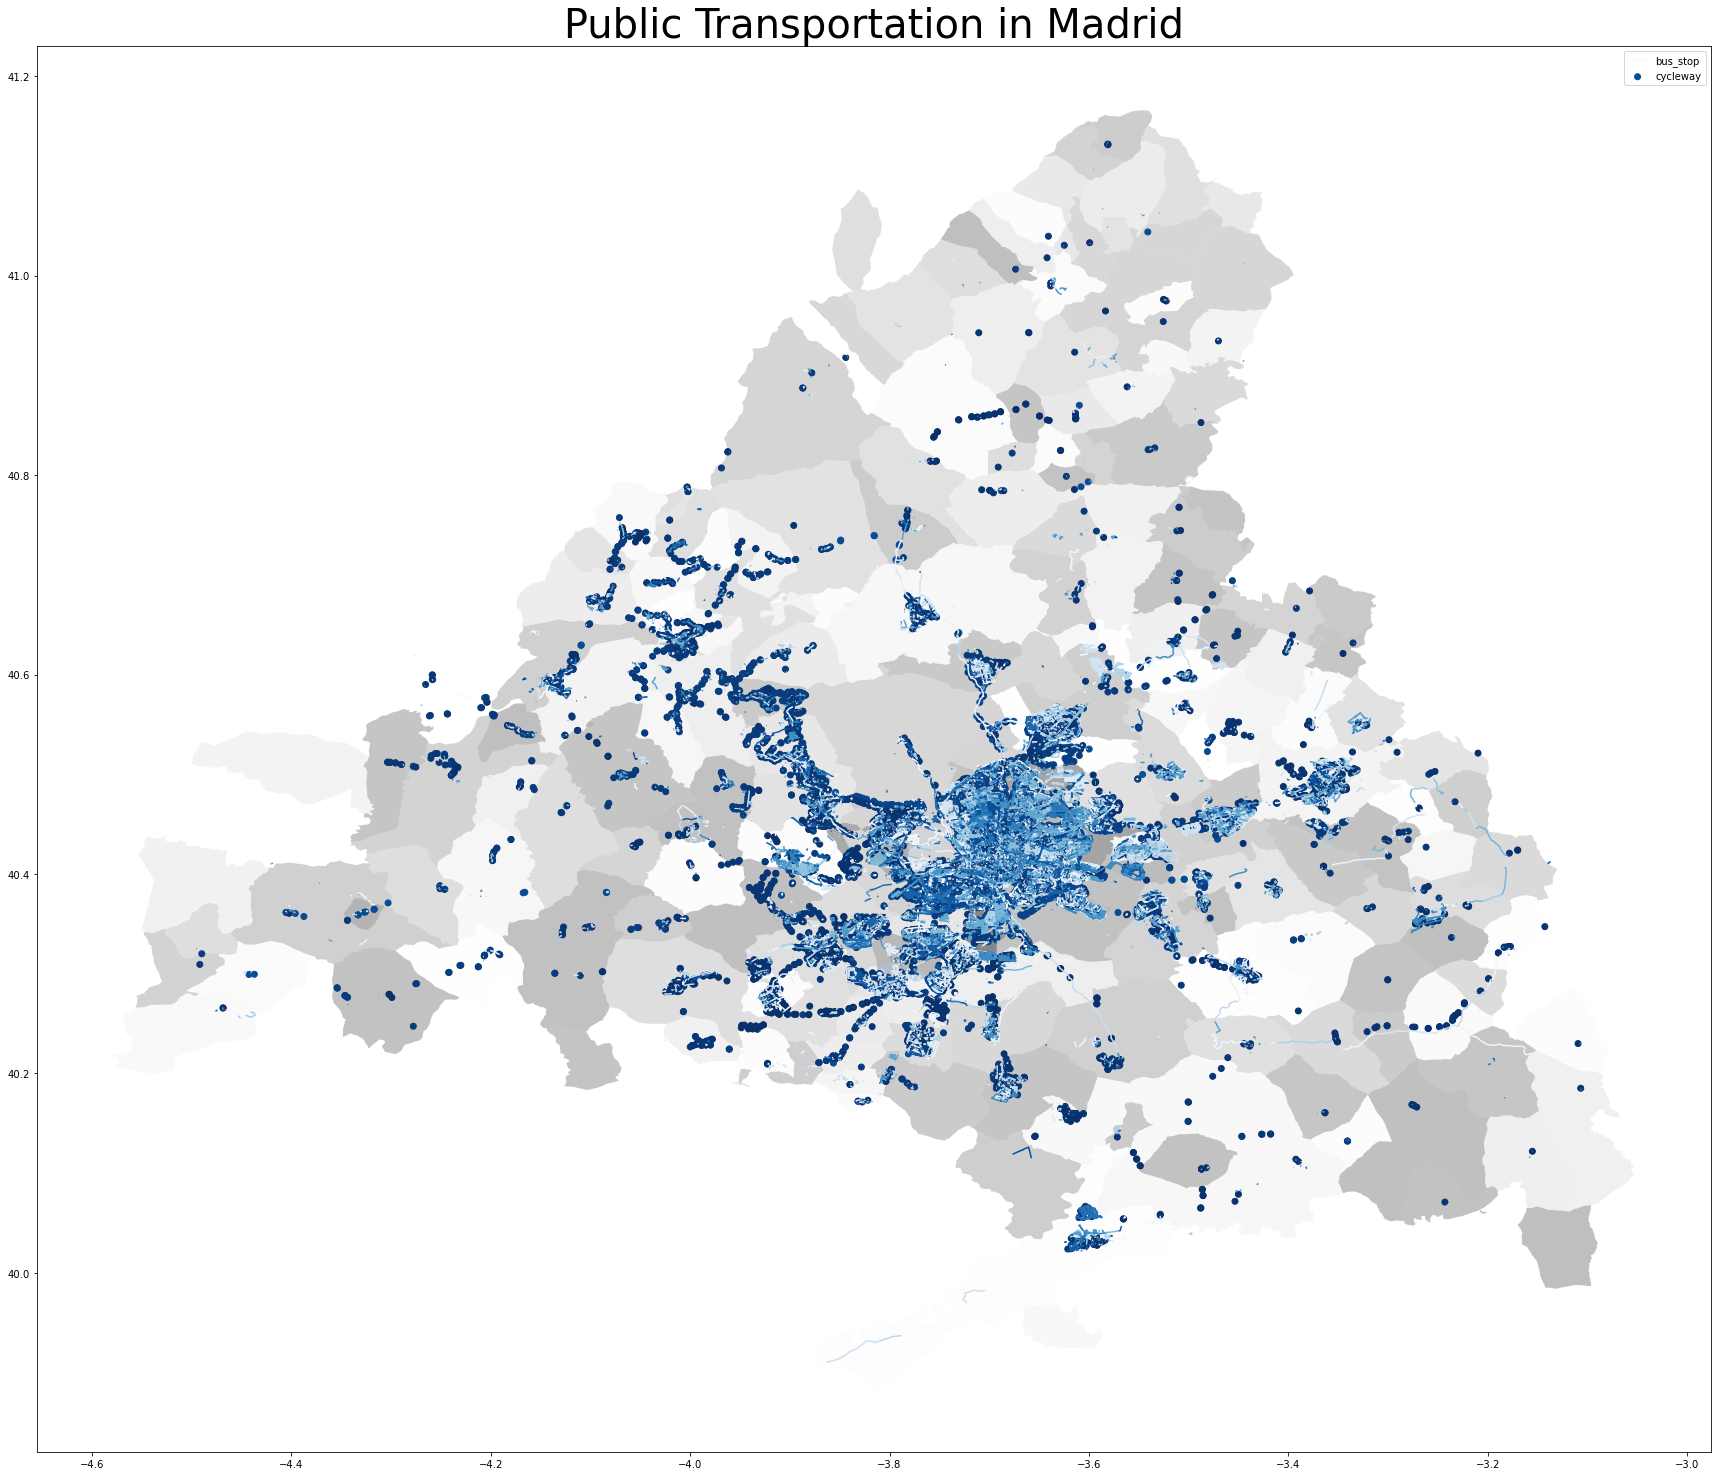

In [102]:
# Plots the amount of bus stops in Madrid
plot_feature(gdf_md, 'highway', transportation)
plt.title("Public Transportation in Madrid", fontsize=40)

Text(0.5, 1.0, 'Public Transportation in Belize')

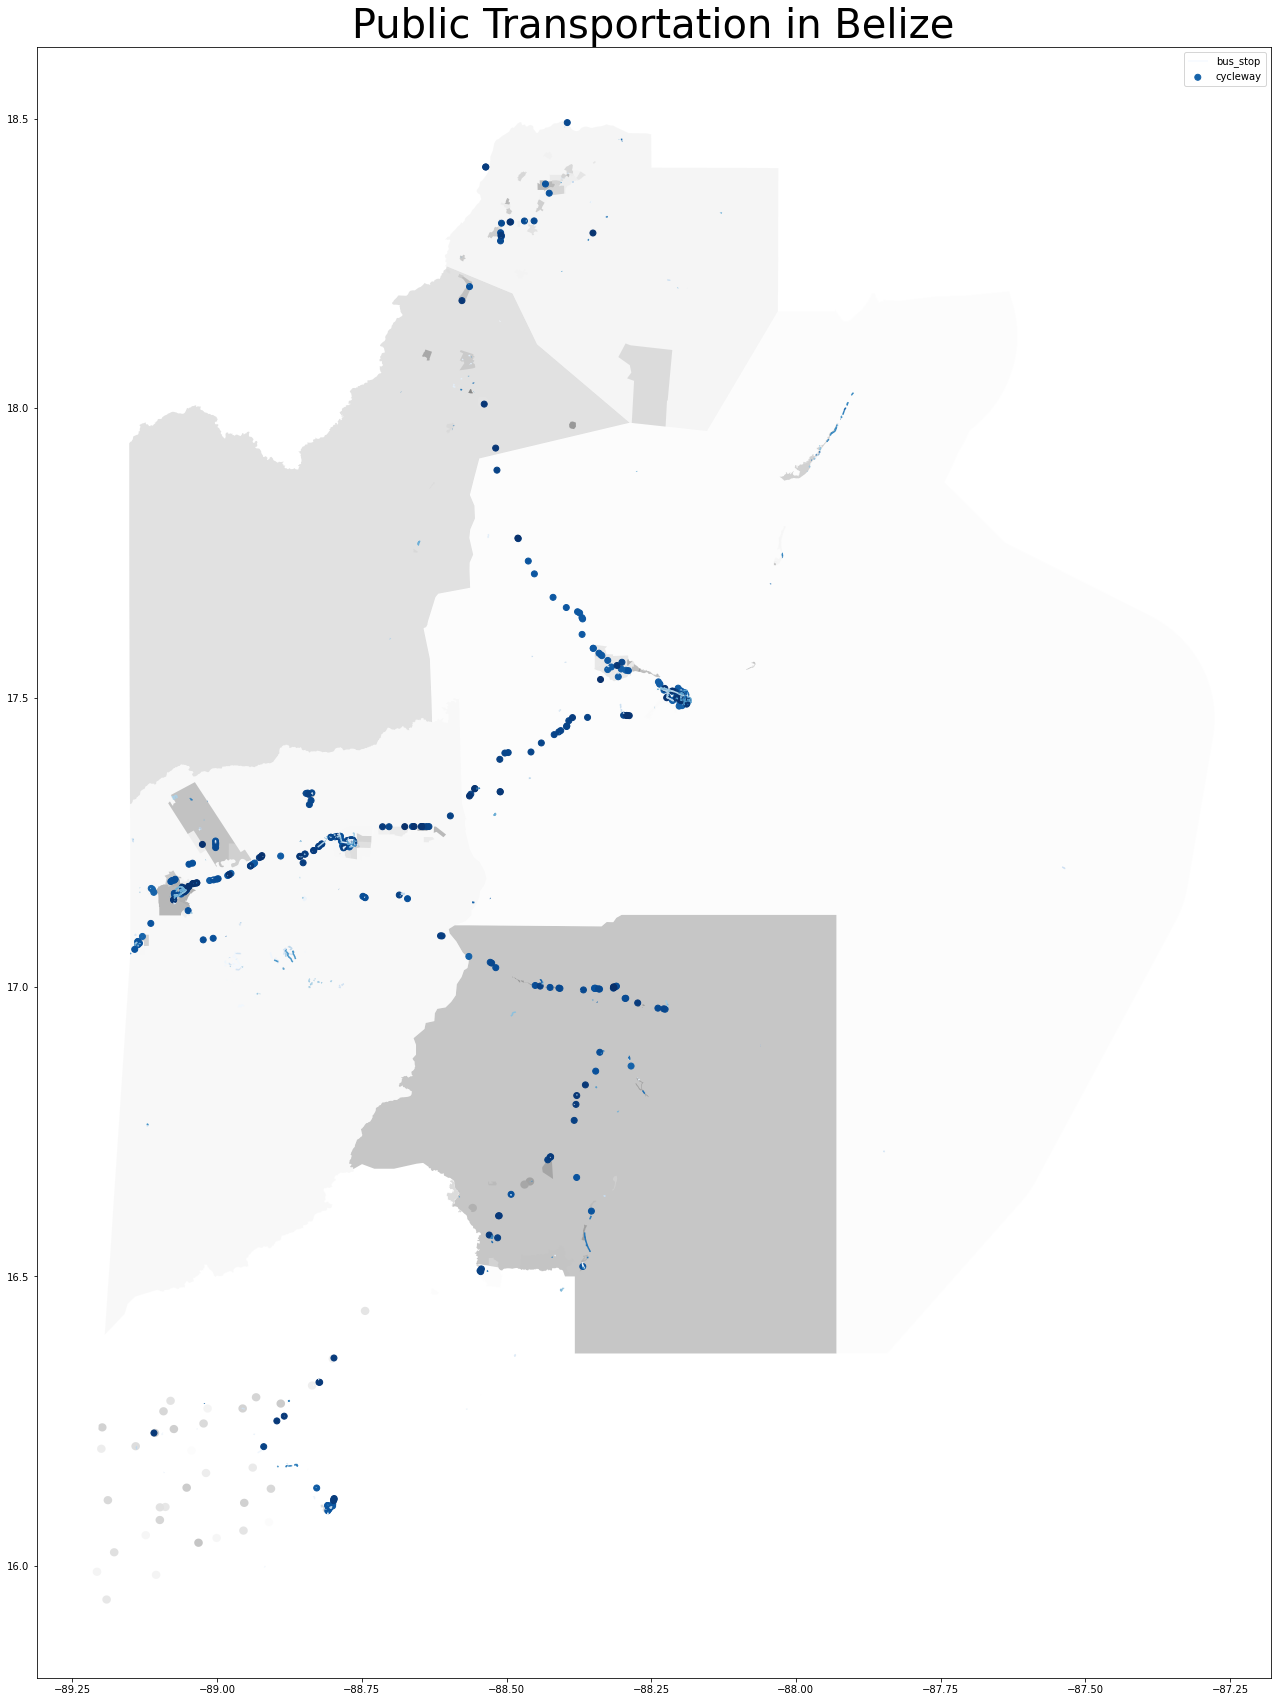

In [103]:
plot_feature(gdf_bz, 'highway', transportation)
plt.title('Public Transportation in Belize', fontsize=40)

### Which country is more enjoyable?

In [98]:
tags = ['natural', 'highway', 'landuse', 'waterway', 'place', 'leisure', 'sport', 'railway']
info = {}
for tag in tags:
    feat = list(gdf_bz[tag].unique())
    info[tag] = feat
info    

{'natural': [nan,
  'water',
  None,
  'wetland',
  'wood',
  'scrub',
  'sand',
  'grassland',
  'beach',
  'reef',
  'shoal',
  'forest',
  'bare_rock',
  'mud',
  'peninsula',
  'bay',
  'atoll',
  'coastline',
  'cave_entrance',
  'cliff',
  'landform',
  'shingle'],
 'highway': [None,
  'trunk',
  'unclassified',
  'primary',
  'tertiary',
  'secondary',
  'residential',
  'pedestrian',
  'service',
  'track',
  'path',
  'proposed',
  'footway',
  'primary_link',
  'trunk_link',
  'cycleway',
  'living_street',
  'steps',
  'tertiary_link',
  'secondary_link',
  'construction',
  'crossing',
  'traffic_signals',
  'mini_roundabout',
  'turning_circle',
  'stop',
  'bus_stop',
  'street_lamp',
  'rest_area',
  'milestone',
  'turning_loop',
  'services',
  'speed_camera',
  'toll_gantry',
  'give_way',
  nan],
 'landuse': [nan,
  None,
  'orchard',
  'farmland',
  'meadow',
  'recreation_ground',
  'residential',
  'forest',
  'quarry',
  'industrial',
  'grass',
  'religious',
  

In [93]:
gdf_bz.tourism.unique()

array([nan, None, 'attraction', 'hotel', 'guest_house', 'camp_site',
       'picnic_site', 'motel', 'gallery', 'information', 'museum',
       'hostel', 'apartment', 'artwork', 'yes', 'resort', 'chalet',
       'lodge', 'zoo', 'alpine_hut', 'wilderness_hut'], dtype=object)

In [94]:
gdf_bz.landuse.unique()

array([nan, None, 'orchard', 'farmland', 'meadow', 'recreation_ground',
       'residential', 'forest', 'quarry', 'industrial', 'grass',
       'religious', 'education', 'commercial', 'cemetery', 'farmyard',
       'landfill', 'aquaculture', 'retail', 'common', 'plant_nursery',
       'military', 'conservation', 'greenhouse_horticulture',
       'construction', 'yes', 'churchyard', 'garages', 'brownfield'],
      dtype=object)

/var/folders/vx/k3zxn9513zq5tbm2k44h1vy00000gn/T/ipykernel_82031/3845004767.py:11: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  df[condition].plot(ax=ax, cmap='Blues')


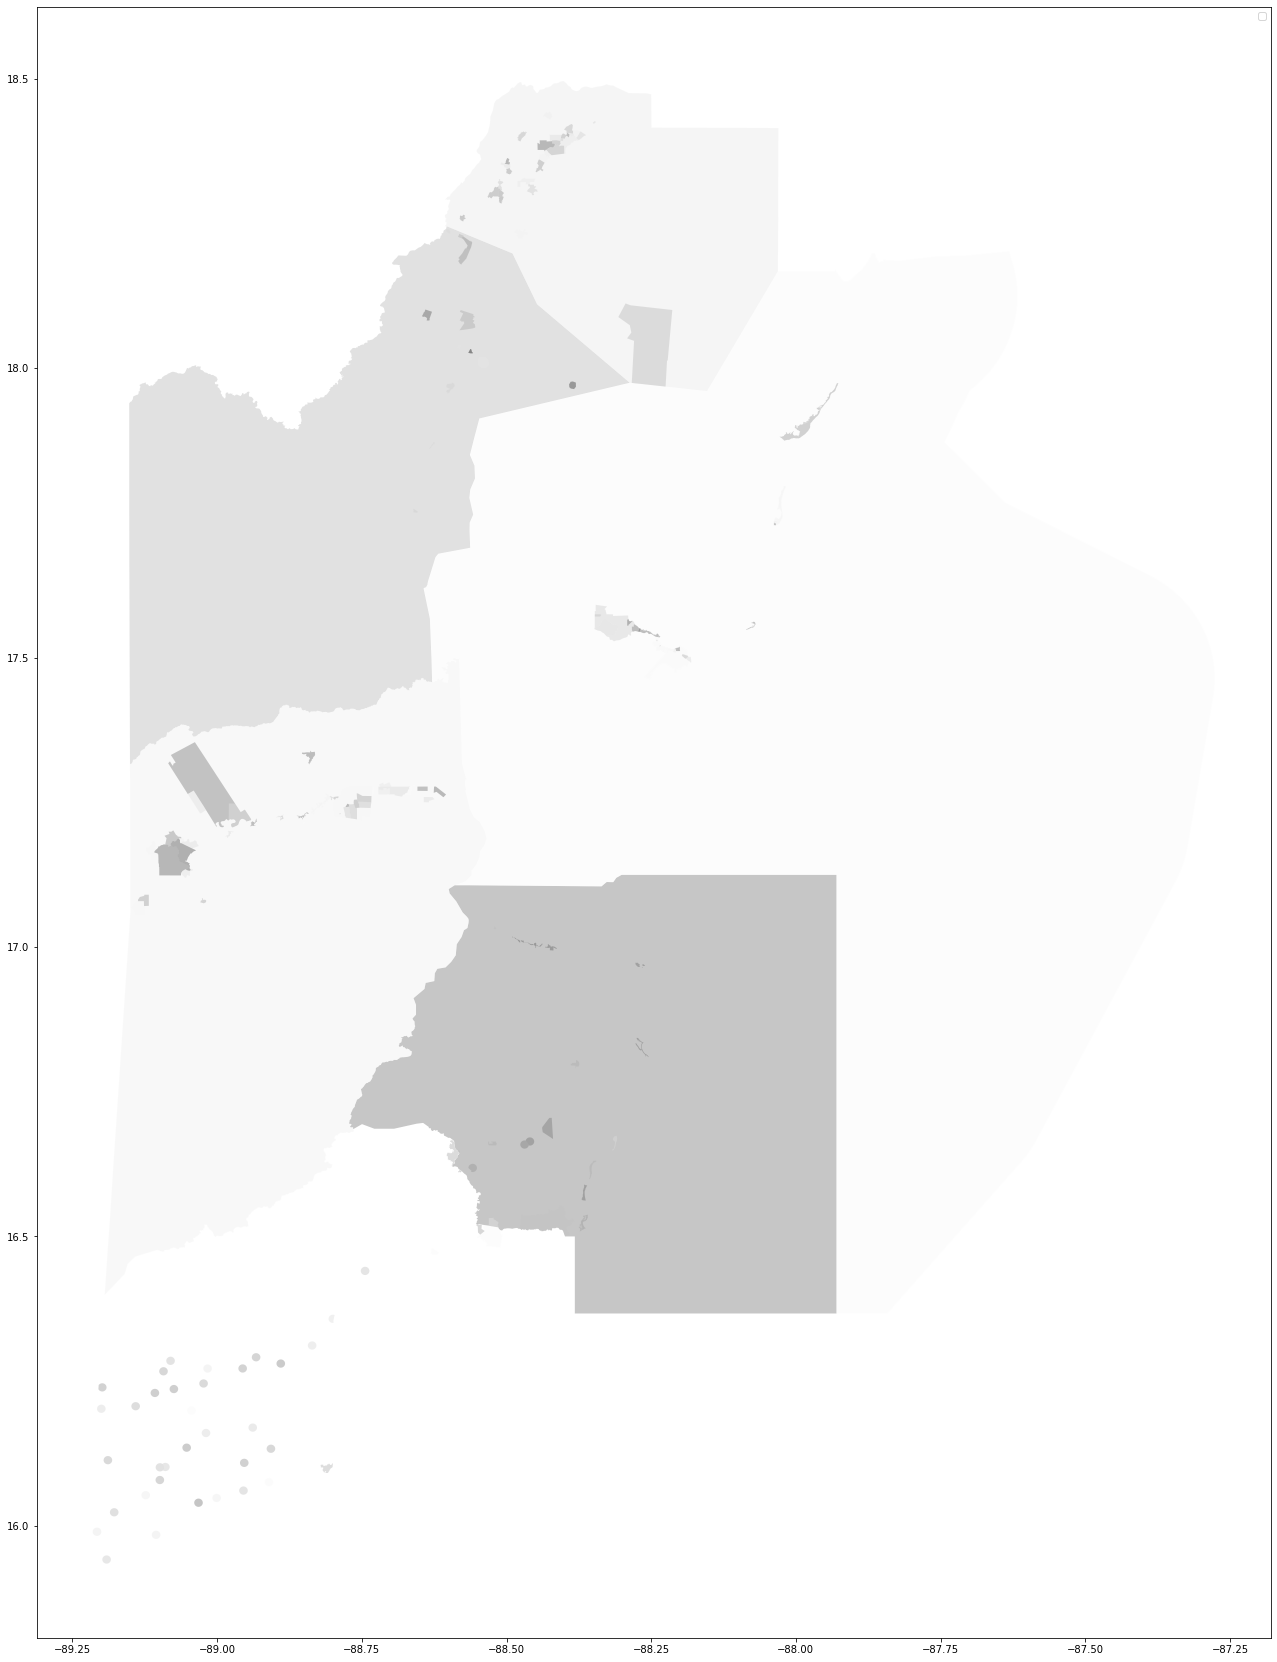

In [101]:
plot_feature(gdf_bz, 'sport', ['cycling'])

### Which country is family-friendly?

### Which country has a strong emphasis on Conservation?

Interesting columns: 'Natural', 'Highway', 'Landuse', 'waterway', 'Place', 'Leisure', 'Sport', 'Railway'

In [ ]:
# size of madrid in km^2
md_size = 603
bz_size